## 数据来源于 icdr2019 数据下载地址 http://rrc.cvc.uab.es/?ch=14
##  百度云地址:https://pan.baidu.com/s/1fmOpTYFmZ4f2UxGDsmKVJA  密码:sh4e

In [1]:
import os
os.chdir('../../')
GPUID='0'##调用GPU序号
os.environ["CUDA_VISIBLE_DEVICES"] = GPUID
import numpy as np
import json
import tensorflow as tf
from glob import glob
from PIL import Image
import cv2


root = '/tmp/train_images/{}.jpg'##icdr 数据目录
with open('/tmp/train_labels.json') as f:
    train_labels = json.loads(f.read())
    
    

In [2]:
def polylines(img,points):
    im = np.zeros(img.shape[:2], dtype = "uint8")
    for point in points:
        b = np.array([point],dtype = np.int32)
        cv2.fillPoly(im, b, 255)
    return im

def check_points(points,w,h):
    ##检测标注是否正确
    check=False
    for point in points:
        for x,y in point:
            if x>w or y>h:
                check=True
                break
        if check:
            break
    return check

def get_points(res):
    points =[]
    for line in res:
        points.append(line['points'])
    return points


def resize_im(img, scale=416, max_scale=608):
    h,w = img.shape[:2]
    f=float(scale)/min(h, w)
    if max_scale is not None:
        if  f*max(h, w)>max_scale:
            f=float(max_scale)/max(h, w)
    newW,newH = int(w*f),int(h*f)
    newW,newH = newW-(newW%32),newH-(newH%32)
    fw = w/newW
    fh = h/newH
    tmpImg = cv2.resize(img, None, None, fx=1/fw, fy=1/fh, interpolation=cv2.INTER_LINEAR)
    return tmpImg,fw,fh

def cleam_im(im):
        avg = 127
        im[im>avg]=255
        im[im<=avg]=0
        y,x = np.where(im==255)
        xmin,ymin,xmax,ymax = (min(x),min(y),max(x),max(y))
        return xmin,ymin,xmax,ymax
    
def adjust_height(h):
    """
    调整box高
    """
    heights = [11, 16, 23, 33, 48, 68, 97, 139, 198, 283]
    N = len(heights)
    for i in range(N-1):
        if h<=heights[i]+heights[i]*0.44/2:
            return heights[i]
    return h

def img_split_to_box(im,splitW = 15,adjust=True):
    """
    均等分割box
    """
    tmpIm = im==255
    h,w = tmpIm.shape[:2]
    num = w//splitW+1
    
    box = []
    for i in range(num-1):
        xmin,ymin,xmax,ymax = splitW*i,0,splitW*(i+1),h
        ##迭代寻找最优ymin,ymax
        childIm = tmpIm[ymin:ymax,xmin:xmax]
        checkYmin = False
        checkYmax = False
        for j in range(ymax):
            if not checkYmin:
                if childIm[j].max():
                    ymin = j
                    checkYmin = True
            if not checkYmax:
                if childIm[ymax-j-1].max():
                    ymax = ymax-j
                    checkYmax = True
               
        if adjust:
            childH = ymax-ymin+1
            cy = (ymax+ymin)/2
            childH = adjust_height(childH)
            ymin = cy-childH/2
            ymax = cy+childH/2     
        box.append([xmin,ymin,xmax,ymax])
    
    return box

def resize_img_box(p,scale=416, max_scale=608,splitW=15,adjust=True):
    path = root.format(p)
    img = cv2.imread(path)
    if img is None:
        return None,[]
    points = get_points(train_labels[f'{p}'])
    h,w = img.shape[:2]
    check = check_points(points,w,h)
    if  check:
        return None,[]
    img,fw,fh = resize_im(img, scale=scale, max_scale=max_scale)
    boxes = []
    for point in points:
        point = [[bx[0]/fw,bx[1]/fh] for bx in point]
        im = polylines(img,[point])
        if im.max()==0:
            continue
            
        xmin,ymin,xmax,ymax = cleam_im(im)
        tmp = im[ymin:ymax,xmin:xmax]
        box = img_split_to_box(tmp,splitW = splitW,adjust=adjust)
        childBoxes = []
        for bx in box:
            xmin_,ymin_,xmax_,ymax_ = bx

            xmin_,ymin_,xmax_,ymax_ = xmin+xmin_,ymin_+ymin,xmax_+xmin,ymax_+ymin
            boxes.append([xmin_,ymin_,xmax_,ymax_])
            #childBoxes.append([xmin_,ymin_,xmax_,ymax_])
        #boxes.append(childBoxes)
    return img,boxes
    
def plot_box(img,boxes,color = (0, 0, 0)):
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), color, 1) #19
    
    return Image.fromarray(tmp) 

## 测试 

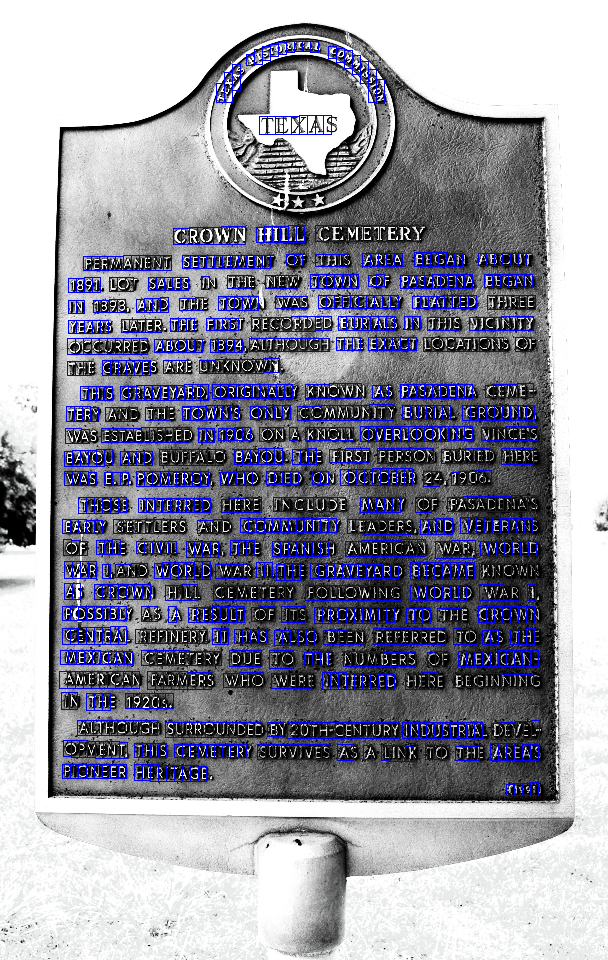

In [4]:
p = list(train_labels.keys())[32]
img,box = resize_img_box(p,scale=608, max_scale=1024,splitW=8,adjust=False)
plot_box(img,box,(0,0,255))


In [5]:
Input =tf.keras.layers.Input
Lambda = tf.keras.layers.Lambda
load_model = tf.keras.models.load_model
Model = tf.keras.models.Model

from text.keras_yolo3 import  preprocess_true_boxes, yolo_text

def clip_box(bbox,im_shape):
    
    # x1 >= 0
    bbox[:, 0] = np.maximum(np.minimum(bbox[:, 0], im_shape[1] - 1), 0)
    # y1 >= 0
    bbox[:, 1] = np.maximum(np.minimum(bbox[:, 1], im_shape[0] - 1), 0)
    # x2 < im_shape[1]
    bbox[:, 2] = np.maximum(np.minimum(bbox[:, 2], im_shape[1] - 1), 0)
    # y2 < im_shape[0]
    bbox[:, 3] = np.maximum(np.minimum(bbox[:, 3], im_shape[0] - 1), 0)

    return bbox

def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

def get_random_data(image,box, input_shape, max_boxes=20, jitter=.3, hue=.1, sat=1.5, val=1.5):
    '''random preprocessing for real-time data augmentation'''
   
    ih, iw = image.shape[:2]
    
    h, w = input_shape

    dx=0
    dy=0
    nw = w
    nh = h

    hue = rand(-hue, hue)
    sat = rand(1, sat) if rand()<.5 else 1/rand(1, sat)
    val = rand(1, val) if rand()<.5 else 1/rand(1, val)
    x = rgb_to_hsv(np.array(image)/255.)
    x[..., 0] += hue
    x[..., 0][x[..., 0]>1] -= 1
    x[..., 0][x[..., 0]<0] += 1
    x[..., 1] *= sat
    x[..., 2] *= val
    x[x>1] = 1
    x[x<0] = 0
    image_data = hsv_to_rgb(x) # numpy array, 0 to 1

    # correct boxes
    box_data = np.zeros((max_boxes,5))
    if len(box)>0:
        np.random.shuffle(box)
        
        box[:, 0:2][box[:, 0:2]<0] = 0
        box[:, 2][box[:, 2]>=w] = w-1
        box[:, 3][box[:, 3]>=h] = h-1
        box_w = box[:, 2] - box[:, 0]
        box_h = box[:, 3] - box[:, 1]
        box = box[np.logical_and(box_w>1, box_h>1)] # discard invalid box
        if len(box)>max_boxes: box = box[:max_boxes]
        box_data[:len(box)] = box
    return image_data, box_data




def data_generator(roots, anchors, num_classes):
    '''data generator for fit_generator
    @@roots:jpg/png
    '''
    n = len(roots)
    np.random.shuffle(roots)
    i = 0

    while True:
        p = roots[i]
        img,boxes = resize_img_box(p,scale=608, max_scale=1024,splitW=8,adjust=True)
        
        i+=1
        if i>=n:
            i=0
        
        if img is None :
            continue
            
        h,w = img.shape[:2]
        input_shape = (h,w)
        boxes = np.array(boxes)
        #boxes = boxes[:,:4]
        boxes = clip_box(boxes,(h,w))
        newBox = np.zeros((len(boxes),5))
        newBox[:,:4] = boxes
        newBox[:,4] =1
        boxes = newBox
        del newBox
        if np.random.randint(0,100)>70:
            if np.random.randint(0,100)>50:
                ##图像水平翻转
                boxes[:,[0,2]] = w-boxes[:,[2,0]]
                
                img = cv2.flip(img,1)
            else:
                ##垂直翻转
                boxes[:,[1,3]] = h-boxes[:,[3,1]]
                
                img = cv2.flip(img,0)
        
        
        
        maxN = 128##随机选取128个box用于训练
        maxN = len(boxes)
        image, box = get_random_data(img,boxes, input_shape,max_boxes=maxN)
        
        image_data = np.array([image])
        box_data = np.array([box])
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], [np.zeros(1)]*4
        

In [6]:
anchors = '8,11, 8,16, 8,23, 8,33, 8,48, 8,97, 8,139, 8,198, 8,283'
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)
class_names = ['none','text',]##text 
num_classes = len(class_names)
textModel = yolo_text(num_classes,anchors,train=True)


In [7]:
roots = list(train_labels.keys())
num_train = int(len(roots)*0.9)
num_val = len(roots)-num_train
np.random.shuffle(roots)
trainLoad = data_generator(roots[:num_train], anchors, num_classes)
testLoad  = data_generator(roots[num_train:], anchors, num_classes)


In [8]:
adam = tf.keras.optimizers.Adam(lr=0.0005)
textModel.compile(optimizer=adam, loss={'xy_loss':lambda y_true, y_pred:y_pred,
                                        'wh_loss':lambda y_true, y_pred:y_pred,
                                        'confidence_loss':lambda y_true, y_pred:y_pred,
                                        'class_loss':lambda y_true, y_pred:y_pred,
                                   }
                                    )

In [9]:
textModel.fit_generator(generator=trainLoad, 
                         steps_per_epoch=num_train, 
                         epochs=5,
                         verbose=1, 
                         callbacks=None,
                         validation_data=testLoad, 
                         validation_steps=num_val)


Epoch 1/5
 205/5042 [>.............................] - ETA: 27:18 - loss: 2705.8111 - class_loss_loss: 34.7854 - xy_loss_loss: 295.0948 - wh_loss_loss: 203.4247 - confidence_loss_loss: 2160.5497

KeyboardInterrupt: 

In [ ]:
textModel.save_weights('/tmp/text.h5')